# Score Distribution Example
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

In [2]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [4]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [5]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32909, 54)

### We should specify the features used in our model:

In [7]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 9)
Unseen Data For Predictions: (4172, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [9]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [143]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm","lr","xgboost"],
    sort="AUC"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7810,0.8598,0.8093,0.7799,0.7943,0.5603,0.5609,0.3310
lightgbm,Light Gradient Boosting Machine,0.7689,0.8486,0.7858,0.7751,0.7804,0.5366,0.5368,0.5100
lr,Logistic Regression,0.6437,0.7009,0.6233,0.6713,0.6463,0.2884,0.2892,0.0150


In [144]:
lr_predictions = predict_model(models.get('lr'), data=df_inference, raw_score=True)
lightgbm_predictions = predict_model(models.get('lightgbm'), data=df_inference, raw_score=True)
xgboost_predictions = predict_model(models.get('xgboost'), data=df_inference, raw_score=True)

### Let's load in our 2021 season data and get retention scores using the model:

In [145]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5094, 9)

### Algorithm: Light Gradient Boosting Machine

In [146]:
#lightgbm_predictions = lightgbm_predictions[lightgbm_predictions["productGrouping"] == "Full Season"]
lightgbm_predictions["Score_1"].value_counts(bins=[0.5,0.6,0.7,0.8,0.9,1.0])

(0.499, 0.6]    697
(0.7, 0.8]      648
(0.6, 0.7]      554
(0.8, 0.9]      293
(0.9, 1.0]      120
Name: Score_1, dtype: int64

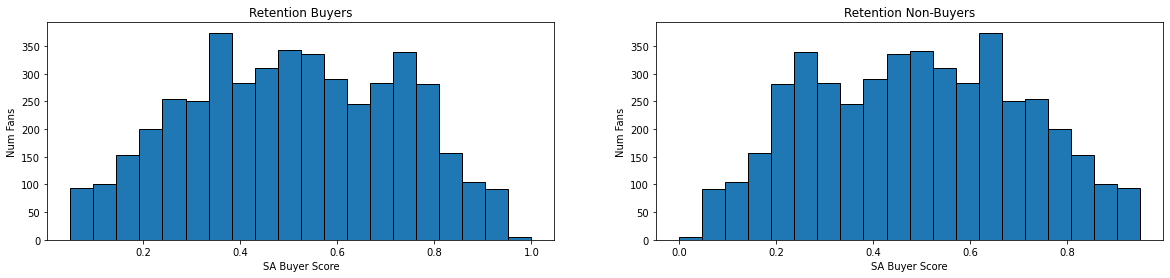

In [157]:
plt.subplot(1, 2, 1) #two rows, 1 column, index 1
plt.title("Retention Buyers")
plt.hist(lightgbm_predictions["Score_1"], bins=20, edgecolor="black", range=(0.05,1.0))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.subplot(1, 2, 2) #two rows, 1 column, index 2
plt.title("Retention Non-Buyers")
plt.hist(lightgbm_predictions["Score_0"], bins=20, edgecolor="black", range=(0.,0.95))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,5)
plt.show()

### Algorithm: Logistic Regression

In [159]:
#lr_predictions = lr_predictions[lr_predictions["productGrouping"] == "Full Season"]
lr_predictions["Score_1"].value_counts(bins=[0.5,0.6,0.7,0.8,0.9,1])

(0.499, 0.6]    805
(0.6, 0.7]      591
(0.7, 0.8]      477
(0.8, 0.9]      134
(0.9, 1.0]       34
Name: Score_1, dtype: int64

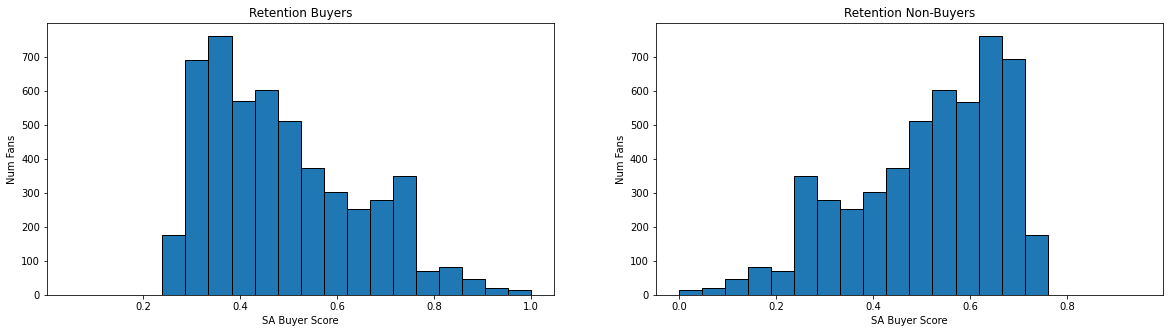

In [161]:
plt.subplot(1, 2, 1) #two rows, 1 column, index 1
plt.title("Retention Buyers")
plt.hist(lr_predictions["Score_1"], bins=20, edgecolor="black", range=(0.05,1.0))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.subplot(1, 2, 2) #two rows, 1 column, index 2
plt.title("Retention Non-Buyers")
plt.hist(lr_predictions["Score_0"], bins=20, edgecolor="black", range=(0.,0.95))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,5)
plt.show()

### Algorithm: XG Boost

In [164]:
#xgboost_predictions = xgboost_predictions[xgboost_predictions["productGrouping"] == "Full Season"]
xgboost_predictions["Score_1"].value_counts(bins=[0.5,0.6,0.7,0.8,0.9,1])

(0.499, 0.6]    560
(0.7, 0.8]      498
(0.6, 0.7]      461
(0.8, 0.9]      453
(0.9, 1.0]      226
Name: Score_1, dtype: int64

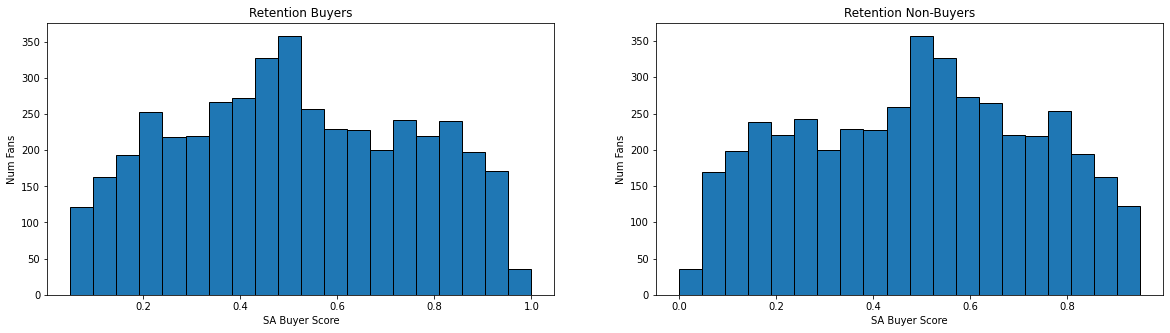

In [163]:
plt.subplot(1, 2, 1) #two rows, 1 column, index 1
plt.title("Retention Buyers")
plt.hist(xgboost_predictions["Score_1"], bins=20, edgecolor="black", range=(0.05,1.0))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.subplot(1, 2, 2) #two rows, 1 column, index 2
plt.title("Retention Non-Buyers")
plt.hist(xgboost_predictions["Score_0"], bins=20, edgecolor="black", range=(0.,0.95))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,5)
plt.show()